# 0.0. IMPORTS

In [3]:
import pandas as pd
import numpy as np
import streamlit as st
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import haversine

import inflection

## 0.1. Helper Variables

In [4]:
RAW_DATA_PATH = f"./dataset/raw/train.csv"

## 0.2. Helper Functions

In [5]:
def show_dataframe_dimensions(dataframe):
    print(f"Number of Rows: {dataframe.shape[0]}")
    print(f"Number of Columns: {dataframe.shape[1]}")
    
    return None

In [6]:
def get_numerical_attributes(dataframe):
    return dataframe.select_dtypes(include=['int64', 'float64'])

In [7]:
def get_first_order_statistics(dataframe):
    # Central Tendency Metrics
    mean = pd.DataFrame(dataframe.apply(np.mean)).T
    median = pd.DataFrame(dataframe.apply(np.median)).T

    # Dispersion Metrics
    min_ = pd.DataFrame(dataframe.apply(min)).T
    max_ = pd.DataFrame(dataframe.apply(max)).T
    range_ = pd.DataFrame(dataframe.apply(lambda x: x.max() - x.min())).T
    std = pd.DataFrame(dataframe.apply(np.std)).T
    skew = pd.DataFrame(dataframe.apply(lambda x: x.skew())).T
    kurtosis = pd.DataFrame(dataframe.apply(lambda x: x.kurtosis())).T

    # Metrics Concatenation
    m = pd.concat([min_, max_, range_, mean, median, std, skew, kurtosis]).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    
    return m

In [8]:
def rename_columns(dataframe):
    df = dataframe.copy()

    title = lambda x: inflection.titleize(x)

    snakecase = lambda x: inflection.underscore(x)

    spaces = lambda x: x.replace(" ", "")

    cols_old = list(df.columns)

    cols_old = list(map(title, cols_old))

    cols_old = list(map(spaces, cols_old))

    cols_new = list(map(snakecase, cols_old))

    df.columns = cols_new

    return df

In [9]:
def adjust_columns_order(dataframe):
    df = dataframe.copy()

    new_cols_order = [
        
        "id",
        "delivery_person",
        "delivery_person_age",
        "delivery_person_ratings",
        "restaurant_latitude",
        "restaurant_longitude",
        "delivery_location_latitude",
        "delivery_location_longitude",
        "distance(km)",
        "order_date",
        "time_orderd",
        "time_order_picked",
        "week_of_year",
        "weatherconditions",
        "road_traffic_density",
        "vehicle_condition",
        "type_of_order",
        "type_of_vehicle",
        "multiple_deliveries",
        "festival",
        "city",
        "time_taken(min)",
    ]

    return df.loc[:, new_cols_order]

In [10]:
def change_types(dataframe):
    df = dataframe.copy()

    df = df[df["delivery_person_age"] != "NaN "]
    df = df[df["delivery_person_ratings"] != "NaN "]
    df = df[df["time_orderd"] != "NaN "]
    df = df[df["road_traffic_density"] != "NaN "]
    df = df[df["multiple_deliveries"] != "NaN "]
    df = df[df["festival"] != "NaN "]
    df = df[df["city"] != "NaN "]

    df['delivery_person_age'] = pd.to_numeric(df['delivery_person_age'], errors='coerce')
    df['delivery_person_ratings'] = df['delivery_person_ratings'].astype(float)
    df['order_date'] = pd.to_datetime(df['order_date'], format='%d-%m-%Y')
    df['time_taken(min)'] = df['time_taken(min)'].apply(lambda x: x.split("(min)")[1]).astype(int)

    return df

In [11]:
def distance(dataframe):
    df = dataframe.copy()

    df["distance(km)"] = df.apply(lambda x: haversine.haversine((x["restaurant_latitude"], x["restaurant_longitude"]), (x["delivery_location_latitude"], x["delivery_location_longitude"])), axis=1)

    return df

In [12]:
def week_of_year(dataframe):
    df = dataframe.copy()

    df['week_of_year'] = df['order_date'].dt.strftime('%U')

    return df

In [13]:
def process_data(file_path):
    df = pd.read_csv(file_path)

    df = df.dropna()

    df = rename_columns(df)

    df = change_types(df)

    df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

    df = distance(df)

    df = week_of_year(df)

    df = df.drop_duplicates()

    df = adjust_columns_order(df)

    df.to_csv("./dataset/processed/data.csv", index=False)

    return df

## 0.3. Helper Configurations

In [14]:
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

## 0.4. Load Data

In [15]:
df_raw = pd.read_csv(RAW_DATA_PATH)
df_raw.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33
2,0x5d6d,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,08:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,(min) 26
3,0x7a6a,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,18:10:00,conditions Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,(min) 21
4,0x70a2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,13:45:00,conditions Cloudy,High,1,Snack,scooter,1,No,Metropolitian,(min) 30


# 1.0. DATA DESCRIPTION

In [356]:
df1 = df_raw.copy()
df1.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33
2,0x5d6d,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,08:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,(min) 26
3,0x7a6a,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,18:10:00,conditions Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,(min) 21
4,0x70a2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,13:45:00,conditions Cloudy,High,1,Snack,scooter,1,No,Metropolitian,(min) 30


## 1.1. Columns Description

| Column | Description |
| :----- | :---------- |
| ID | ID do restaurante |
| delivery_person | ID do entregador |
| delivery_person_age | Idade do entregador |
| delivery_person_ratings | Avaliação do entregador |
| restaurant_latitude | Latitude do restaurante |
| restaurant_longitude | Longitude do restaurante |
| delivery_location_latitude | Latitude do local de entrega |
| delivery_location_longitude | Longitude do local de entrega |
| order_date | Data do pedido |
| time_orderd | Horário do pedido |
| time_orderd_picked | Horário do pedido retirado |
| weatherconditions | Condições climáticas; Fog - Stormy - Cloudy - Sandstorms - Windy - Sunny |
| road_traffic_density | Densidade do tráfego; Low - Medium - High - Jam |
| vehicle_condition | Condição do veículo; 0 - 1 - 2 |
| type_of_order | Tipo de pedido; Snack - Meal - Drinks - Buffet |
| type_of_vehicle | Tipo de veículo; motorcycle - scooter - eletric_scooter - bicycle |
| multiple_deliveries | Se o restaurante faz entregas múltiplas; 0 - 1 - 2 - 3 |
| festival | Se o pedido foi entregue durante o Festival; Sim ou Não |
| city | Tipos de cidade; Metropolitian - Semi-Urban - Urban |
| time_taken(min) | Tempo de entrega em minutos |

## 1.2. Rename Columns

In [256]:
df1 = rename_columns(df1)
df1.head()

,id,delivery_person,delivery_person_age,delivery_person_ratings,restaurant_latitude,restaurant_longitude,delivery_location_latitude,delivery_location_longitude,order_date,time_orderd,time_order_picked,weatherconditions,road_traffic_density,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city,time_taken(min)
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33
2,0x5d6d,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,08:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,(min) 26
3,0x7a6a,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,18:10:00,conditions Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,(min) 21
4,0x70a2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,13:45:00,conditions Cloudy,High,1,Snack,scooter,1,No,Metropolitian,(min) 30


## 1.3. Data Dimensions

In [357]:
show_dataframe_dimensions(df1)

Number of Rows: 45593
Number of Columns: 20


## 1.4. Data Types

In [358]:
df1.dtypes

ID                              object
Delivery_person_ID              object
Delivery_person_Age             object
Delivery_person_Ratings         object
Restaurant_latitude            float64
Restaurant_longitude           float64
Delivery_location_latitude     float64
Delivery_location_longitude    float64
Order_Date                      object
Time_Orderd                     object
Time_Order_picked               object
Weatherconditions               object
Road_traffic_density            object
Vehicle_condition                int64
Type_of_order                   object
Type_of_vehicle                 object
multiple_deliveries             object
Festival                        object
City                            object
Time_taken(min)                 object
dtype: object

## 1.5. Checking NA

In [240]:
df1.isna().sum()

id                             0
delivery_person                0
delivery_person_age            0
delivery_person_ratings        0
restaurant_latitude            0
restaurant_longitude           0
delivery_location_latitude     0
delivery_location_longitude    0
order_date                     0
time_orderd                    0
time_order_picked              0
weatherconditions              0
road_traffic_density           0
vehicle_condition              0
type_of_order                  0
type_of_vehicle                0
multiple_deliveries            0
festival                       0
city                           0
time_taken(min)                0
dtype: int64

In [241]:
df1[df1 == "NaN "].count()

id                                0
delivery_person                   0
delivery_person_age            1854
delivery_person_ratings        1908
restaurant_latitude               0
restaurant_longitude              0
delivery_location_latitude        0
delivery_location_longitude       0
order_date                        0
time_orderd                    1731
time_order_picked                 0
weatherconditions                 0
road_traffic_density            601
vehicle_condition                 0
type_of_order                     0
type_of_vehicle                   0
multiple_deliveries             993
festival                        228
city                           1200
time_taken(min)                   0
dtype: int64

## 1.6. Treating NA

In [22]:
df1 = df1.dropna()
df1.isna().sum()

id                             0
delivery_person                0
delivery_person_age            0
delivery_person_ratings        0
restaurant_latitude            0
restaurant_longitude           0
delivery_location_latitude     0
delivery_location_longitude    0
order_date                     0
time_orderd                    0
time_order_picked              0
weatherconditions              0
road_traffic_density           0
vehicle_condition              0
type_of_order                  0
type_of_vehicle                0
multiple_deliveries            0
festival                       0
city                           0
time_taken(min)                0
dtype: int64

In [23]:
df1.delivery_person_age.value_counts().reset_index()

,delivery_person_age,count
0,35,2262
1,36,2260
2,37,2227
3,30,2226
4,38,2219
5,24,2210
6,32,2202
7,22,2196
8,29,2191
9,33,2187


In [432]:
df1 = df1[df1["delivery_person_age"] != "NaN "]
df1 = df1[df1["delivery_person_ratings"] != "NaN "]
df1 = df1[df1["time_orderd"] != "NaN "]
df1 = df1[df1["road_traffic_density"] != "NaN "]
df1 = df1[df1["multiple_deliveries"] != "NaN "]
df1 = df1[df1["festival"] != "NaN "]
df1 = df1[df1["city"] != "NaN "]
df1['festival'] = df1['festival'].apply(lambda x: x.strip())

In [342]:
df1[df1 == "No "].count()

id                             0
delivery_person                0
delivery_person_age            0
delivery_person_ratings        0
restaurant_latitude            0
restaurant_longitude           0
delivery_location_latitude     0
delivery_location_longitude    0
order_date                     0
time_orderd                    0
time_order_picked              0
weatherconditions              0
road_traffic_density           0
vehicle_condition              0
type_of_order                  0
type_of_vehicle                0
multiple_deliveries            0
festival                       0
city                           0
time_taken(min)                0
dtype: int64

In [375]:
df1[df1 == "NaN "].count()

id                             0
delivery_person                0
delivery_person_age            0
delivery_person_ratings        0
restaurant_latitude            0
restaurant_longitude           0
delivery_location_latitude     0
delivery_location_longitude    0
order_date                     0
time_orderd                    0
time_order_picked              0
weatherconditions              0
road_traffic_density           0
vehicle_condition              0
type_of_order                  0
type_of_vehicle                0
multiple_deliveries            0
festival                       0
city                           0
time_taken(min)                0
dtype: int64

## 1.7. Change Types

### 1.7.0 delivery_person_age

In [376]:
df1['delivery_person_age'] = pd.to_numeric(df1['delivery_person_age'], errors='coerce')
df1.delivery_person_age.dtypes

dtype('int64')

### 1.7.1 delivery_person_ratings

In [377]:
df1['delivery_person_ratings'] = df1['delivery_person_ratings'].astype(float)
df1.delivery_person_ratings.dtypes

dtype('float64')

### 1.7.2 order_date

In [378]:
df1['order_date'] = pd.to_datetime(df1['order_date'], format='%d-%m-%Y')
df1.dtypes

id                                     object
delivery_person                        object
delivery_person_age                     int64
delivery_person_ratings               float64
restaurant_latitude                   float64
restaurant_longitude                  float64
delivery_location_latitude            float64
delivery_location_longitude           float64
order_date                     datetime64[ns]
time_orderd                            object
time_order_picked                      object
weatherconditions                      object
road_traffic_density                   object
vehicle_condition                       int64
type_of_order                          object
type_of_vehicle                        object
multiple_deliveries                    object
festival                               object
city                                   object
time_taken(min)                        object
dtype: object

### 1.7.3 time_taken(min)

In [379]:
df1['time_taken(min)'] = df1['time_taken(min)'].apply(lambda x: x.split("(min)")[1]).astype(int)

In [380]:
df1.head(1)

,id,delivery_person,delivery_person_age,delivery_person_ratings,restaurant_latitude,restaurant_longitude,delivery_location_latitude,delivery_location_longitude,order_date,time_orderd,time_order_picked,weatherconditions,road_traffic_density,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city,time_taken(min)
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,24


In [381]:
df1.dtypes

id                                     object
delivery_person                        object
delivery_person_age                     int64
delivery_person_ratings               float64
restaurant_latitude                   float64
restaurant_longitude                  float64
delivery_location_latitude            float64
delivery_location_longitude           float64
order_date                     datetime64[ns]
time_orderd                            object
time_order_picked                      object
weatherconditions                      object
road_traffic_density                   object
vehicle_condition                       int64
type_of_order                          object
type_of_vehicle                        object
multiple_deliveries                    object
festival                               object
city                                   object
time_taken(min)                         int32
dtype: object

## 1.8 Descriptive Statistics

In [259]:
numerical_data = get_numerical_attributes(df1)

### 1.8.1 Numerical Data

In [260]:
get_first_order_statistics(numerical_data)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,restaurant_latitude,-30.905562,30.914057,61.819619,17.017729,18.546947,8.185019,-1.361583,3.713716
1,restaurant_longitude,-88.366217,88.433452,176.799669,70.231332,75.898497,22.883396,-3.220159,10.303039
2,delivery_location_latitude,0.010000,31.054057,31.044057,17.465186,18.633934,7.335042,-0.701066,0.264346
3,delivery_location_longitude,0.010000,88.563452,88.553452,70.845702,76.002574,21.118580,-2.956385,7.104451
4,vehicle_condition,0.000000,3.000000,3.000000,1.023359,1.000000,0.839056,0.071853,-1.315002


# 2. Answers

In [16]:
df2 = process_data(RAW_DATA_PATH)
df2.head(1)

,id,delivery_person,delivery_person_age,delivery_person_ratings,restaurant_latitude,restaurant_longitude,delivery_location_latitude,delivery_location_longitude,distance(km),order_date,time_orderd,time_order_picked,week_of_year,weatherconditions,road_traffic_density,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city,time_taken(min)
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,3.025153,2022-03-19,11:30:00,11:45:00,11,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,24


## Do lado da empresa:

### 1. Quantidade de pedidos por dia.

In [360]:
df2.groupby(df2['order_date'].dt.date)['id'].count().reset_index()

,order_date,id
0,2022-02-11,895
1,2022-02-12,788
2,2022-02-13,859
3,2022-02-14,782
4,2022-02-15,851
5,2022-02-16,786
6,2022-02-17,847
7,2022-02-18,777
8,2022-03-01,1026
9,2022-03-02,925


### 2. Quantidade de pedidos por semana.

In [361]:
df_aux = df2.loc[:, ["id", "week_of_year"]].groupby("week_of_year").count().reset_index()
df_aux

,week_of_year,id
0,06,1683
1,07,4902
2,09,4947
3,10,6700
4,11,6844
5,12,5806
6,13,6657
7,14,3829


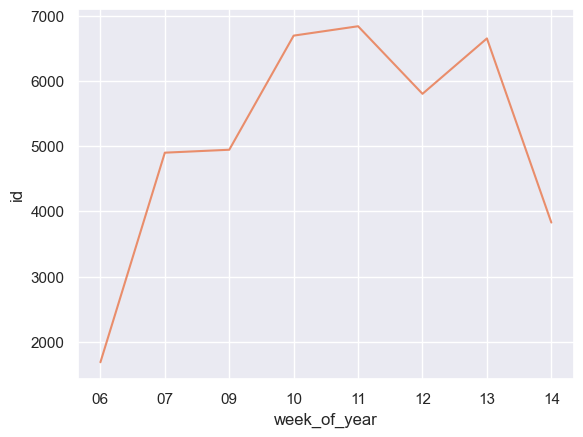

In [362]:
sns.set_theme(style="darkgrid", palette="flare")
sns.lineplot(data=df_aux, x="week_of_year", y="id")
plt.show()

### 3. Distribuição dos pedidos por tipo de tráfego.

In [363]:
df_aux = df2.groupby("road_traffic_density")["id"].count().reset_index()
df_aux["entregas_perc"] = df_aux["id"] / df_aux["id"].sum()
df_aux

,road_traffic_density,id,entregas_perc
0,High,4103,0.099183
1,Jam,13159,0.318096
2,Low,13981,0.337967
3,Medium,10125,0.244754


In [364]:
fig = px.pie(df_aux, 
             values="entregas_perc", names="road_traffic_density",
             title="Traffic Order Share",
             color_discrete_sequence=px.colors.sequential.Blues
             )
fig.show()


### 4. Comparação do volume de pedidos por cidade e tipo de tráfego.

In [365]:
df_aux = df2.groupby(["city", "road_traffic_density"]).size().reset_index(name="orders")
df_aux

,city,road_traffic_density,orders
0,Metropolitian,High,3206
1,Metropolitian,Jam,10547
2,Metropolitian,Low,10178
3,Metropolitian,Medium,7891
4,Semi-Urban,High,16
5,Semi-Urban,Jam,126
6,Semi-Urban,Medium,10
7,Urban,High,881
8,Urban,Jam,2486
9,Urban,Low,3803


In [268]:
fig = px.scatter(df_aux,
                 x = "city", y = "road_traffic_density", size = "orders", color = "city", color_discrete_sequence=px.colors.qualitative.Set1)
fig.show()

### 5. A quantidade de pedidos por entregador por semana.

In [374]:
df_aux = df2.groupby("week_of_year").agg(id=("id", "count"), delivery_person=("delivery_person", "nunique")).reset_index()
df_aux["order_by_deliver"] = df_aux["id"] / df_aux["delivery_person"]
df_aux

,week_of_year,id,delivery_person,order_by_deliver
0,06,1683,598,2.814381
1,07,4902,600,8.170000
2,09,4947,720,6.870833
3,10,6700,720,9.305556
4,11,6844,720,9.505556
5,12,5806,720,8.063889
6,13,6657,720,9.245833
7,14,3829,719,5.325452


In [375]:
fig = px.line(df_aux, x="week_of_year", y="order_by_deliver")
fig.show()

### 6. A localização central de cada cidade por tipo de tráfego.

In [376]:
df2.groupby(['city', 'road_traffic_density']).agg({
    'restaurant_latitude': 'median',
    'restaurant_longitude': 'median'
}).reset_index()

,city,road_traffic_density,restaurant_latitude,restaurant_longitude
0,Metropolitian,High,18.539299,76.284134
1,Metropolitian,Jam,18.562450,75.902847
2,Metropolitian,Low,18.551440,75.898497
3,Metropolitian,Medium,18.551440,75.902847
4,Semi-Urban,High,20.423478,76.784976
5,Semi-Urban,Jam,17.434965,76.618496
6,Semi-Urban,Medium,21.160234,77.661931
7,Urban,High,18.593481,75.892574
8,Urban,Jam,18.554382,75.893400
9,Urban,Low,18.546947,75.892574


## Do lado do entregador:

### 1. A menor e maior idade dos entregadores.

In [17]:
#Menor idade
df2["delivery_person_age"].min()

20

In [18]:
#Maior idade
df2["delivery_person_age"].max()

39

### 2. A pior e a melhor condição de veículos.

In [19]:
#Pior condição de veículo (Média)
df2.groupby("type_of_vehicle")["vehicle_condition"].mean().sort_values(ascending=True).reset_index()

,type_of_vehicle,vehicle_condition
0,motorcycle,0.568313
1,scooter,1.508271
2,electric_scooter,2.000000


In [20]:
#Pior condição do veículo (Mediana)
df2.groupby("type_of_vehicle")["vehicle_condition"].median().sort_values(ascending=True).reset_index()

,type_of_vehicle,vehicle_condition
0,motorcycle,0.0
1,electric_scooter,2.0
2,scooter,2.0


In [21]:
#Melhor condição do veículo (Média)
df2.groupby("type_of_vehicle")["vehicle_condition"].mean().sort_values(ascending=False).reset_index()

,type_of_vehicle,vehicle_condition
0,electric_scooter,2.000000
1,scooter,1.508271
2,motorcycle,0.568313


In [22]:
#Melhor condição do veículo (Mediana)
df2.groupby("type_of_vehicle")["vehicle_condition"].median().sort_values(ascending=False).reset_index()

,type_of_vehicle,vehicle_condition
0,electric_scooter,2.0
1,scooter,2.0
2,motorcycle,0.0


In [24]:
#Nome do veículo com a melhor condição
df2.groupby("type_of_vehicle")["vehicle_condition"].mean().sort_values(ascending=False).reset_index().head(1)

,type_of_vehicle,vehicle_condition
0,electric_scooter,2.0


### 3. A avaliação média por entregador.

In [432]:
df2.loc[:,["delivery_person","delivery_person_ratings"]].groupby("delivery_person").mean().reset_index()

,delivery_person,delivery_person_ratings
0,AGRRES010DEL01,4.761538
1,AGRRES010DEL02,4.671429
2,AGRRES010DEL03,4.575000
3,AGRRES01DEL01,4.522222
4,AGRRES01DEL02,4.700000
...,...,...
1315,VADRES19DEL02,4.632727
1316,VADRES19DEL03,4.670270
1317,VADRES20DEL01,4.620370
1318,VADRES20DEL02,4.591111


### 4. A avaliação média e o desvio padrão por tipo de tráfego.

In [385]:
df2.groupby("road_traffic_density")["delivery_person_ratings"].agg(["mean", "std"]).reset_index()

,road_traffic_density,mean,std
0,High,4.652230,0.273044
1,Jam,4.594019,0.329778
2,Low,4.645011,0.338080
3,Medium,4.660138,0.274245


### 5. A avaliação média e o desvio padrão por condições climáticas.

In [387]:
df2.groupby("weatherconditions")["delivery_person_ratings"].agg(["mean", "std"]).reset_index()

,weatherconditions,mean,std
0,conditions Cloudy,4.651871,0.281197
1,conditions Fog,4.652965,0.275060
2,conditions Sandstorms,4.611748,0.310852
3,conditions Stormy,4.611819,0.313096
4,conditions Sunny,4.654868,0.396674
5,conditions Windy,4.616128,0.304565


### 6. Os 10 entregadores mais rápidos por cidade.

In [388]:
df2.groupby(['city', 'delivery_person'])['time_taken(min)'].mean().sort_values().groupby('city').head(10).reset_index()

,city,delivery_person,time_taken(min)
0,Urban,LUDHRES01DEL02,10.000000
1,Urban,BHPRES11DEL03,10.000000
2,Urban,AURGRES02DEL03,10.000000
3,Urban,KOCRES04DEL02,10.000000
4,Urban,DEHRES08DEL02,10.000000
5,Urban,DEHRES20DEL03,10.000000
6,Urban,LUDHRES07DEL03,11.000000
7,Urban,BHPRES13DEL01,11.000000
8,Urban,KOLRES05DEL01,11.000000
9,Urban,CHENRES07DEL01,11.666667


### 7. Os 10 entregadores mais lentos por cidade.

In [389]:
df2.groupby(['city', 'delivery_person'])['time_taken(min)'].mean().sort_values(ascending=False).groupby('city').head(10).reset_index()

,city,delivery_person,time_taken(min)
0,Semi-Urban,JAPRES09DEL01,54.000000
1,Semi-Urban,GOARES18DEL01,54.000000
2,Semi-Urban,VADRES13DEL01,54.000000
3,Semi-Urban,PUNERES13DEL02,54.000000
4,Semi-Urban,MYSRES13DEL02,54.000000
5,Semi-Urban,MYSRES12DEL01,54.000000
6,Semi-Urban,MYSRES04DEL03,54.000000
7,Semi-Urban,LUDHRES05DEL01,54.000000
8,Semi-Urban,JAPRES14DEL02,54.000000
9,Semi-Urban,JAPRES03DEL02,54.000000


## Do lado do restaurante:

### 1. A quantidade de entregadores únicos.

In [390]:
len(df2.loc[:, "delivery_person"].unique())

1320

### 2. A distância média dos restaurantes e dos locais de entrega.

In [391]:
df2['distance'] = df2.apply(lambda x: haversine.haversine((x['restaurant_latitude'], x['restaurant_longitude']),
                                                          (x['delivery_location_latitude'], x['delivery_location_longitude'])), axis=1)
df2["distance"].mean()

26.912100440866567

### 3. O tempo médio e o desvio padrão de entrega por cidade.

In [393]:
df2.groupby("city")["time_taken(min)"].agg(["mean", "std"]).reset_index()

,city,mean,std
0,Metropolitian,27.429860,9.134286
1,Semi-Urban,49.710526,2.724992
2,Urban,23.209495,8.859189


### 4. O tempo médio e o desvio padrão de entrega por cidade e tipo de pedido.

In [394]:
df2.groupby(["city", "type_of_order"])["time_taken(min)"].agg(["mean", "std"]).reset_index()

,city,type_of_order,mean,std
0,Metropolitian,Buffet,27.301935,9.155644
1,Metropolitian,Drinks,27.324962,9.041698
2,Metropolitian,Meal,27.618877,9.215624
3,Metropolitian,Snack,27.467867,9.119682
4,Semi-Urban,Buffet,49.707317,2.731702
5,Semi-Urban,Drinks,49.625000,2.459347
6,Semi-Urban,Meal,50.300000,3.041665
7,Semi-Urban,Snack,49.408163,2.707385
8,Urban,Buffet,23.566337,9.060933
9,Urban,Drinks,23.308885,8.925721


### 5. O tempo médio e o desvio padrão de entrega por cidade e tipo de tráfego.

In [395]:
df2.groupby(["city", "road_traffic_density"])["time_taken(min)"].agg(["mean", "std"]).reset_index()

,city,road_traffic_density,mean,std
0,Metropolitian,High,28.145976,7.904494
1,Metropolitian,Jam,31.978193,9.477798
2,Metropolitian,Low,22.259874,6.795802
3,Metropolitian,Medium,27.728045,8.309769
4,Semi-Urban,High,50.125000,2.629956
5,Semi-Urban,Jam,49.841270,2.717095
6,Semi-Urban,Medium,47.400000,2.011080
7,Urban,High,24.305335,8.494842
8,Urban,Jam,27.989541,10.078679
9,Urban,Low,19.445964,6.319847


### 6. O tempo médio de entrega durantes os Festivais.

In [428]:
df2[df2['festival'] == 'Yes']['time_taken(min)'].mean()

45.51860744297719